# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
## The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score

In [38]:
# Import essential libraries
#from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
from langchain.vectorstores import FAISS
#from langchain.embeddings import OpenAIEmbeddings

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.runnables import RunnableMap
from langchain.embeddings.cache import CacheBackedEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough

from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

import matplotlib.pyplot as plt

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
# Load the files as documents

docs = []  # List to hold the documents

for folder in ['contractnli', 'cuad', 'maud', 'privacy_qa']:
    folder_path = f"./rag_legal/corpus/{folder}"
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            loader = TextLoader(os.path.join(folder_path, filename), encoding='utf-8')
            document = loader.load()[0]
            document.metadata["source"] = filename
            document.metadata["category"] = folder
            docs.append(document)


In [4]:
# check the first document in doc
print(docs[1].page_content[:500])  # Display first 500 characters

Confidentiality Agreement
This Confidentiality Agreement (the “Agreement”) has been prepared on behalf of bpost SA/NV, a limited liability company of public law, and the City of Brussels (the “Sellers”) with regard to the divestment of their respective surface areas (the “Sale”) in the Munt Center/Centre Monnaie (the “Munt”).
In consideration of the Sellers agreeing to disclose confidential information (the “Confidential Information”) to the Candidate (“Disclosee”), the latter hereby undertakes 


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

# Clean and preprocess the data
Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [5]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:

# Define your text cleaning function to remove special characters, emails, and phone numbers and 
# to normalize text to lowercase and remove stop words

from nltk.corpus import stopwords

# Load English stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text: str) -> str:
    # Remove emails and phone numbers
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\+?\d[\d\-\(\) ]{7,}\d', '', text)
    
    # Remove special characters except common punctuation
    text = re.sub(r'[^\w\s\.,;:\-\(\)]', '', text)
    
    # Lowercase and normalize spaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words using a library or predefined list
  
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text


In [7]:
# Apply clean_text to each document in `docs`
for doc in docs:
    raw_text = doc.page_content
    cleaned_text = clean_text(raw_text)
    doc.page_content = cleaned_text

### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [8]:
# Calculate the average, maximum and minimum document length.

doc_lengths = [len(doc.page_content.split()) for doc in docs]

average_length = sum(doc_lengths) / len(doc_lengths)
max_length = max(doc_lengths)
min_length = min(doc_lengths)
print(f"Average document length: {average_length}")
print(f"Maximum document length: {max_length}")
print(f"Minimum document length: {min_length}")



Average document length: 9276.018624641834
Maximum document length: 87912
Minimum document length: 148


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [34]:
# Find frequency of occurence of words

from collections import Counter
word_counts = Counter()
for doc in docs:
    words = doc.page_content.split()
    word_counts.update(words)
# Display the 20 most common words
most_common_words = word_counts.most_common(20)
print("Most common words:")
for word, count in most_common_words:
    print(f"{word}: {count}")



Most common words:
company: 131502
shall: 104461
section: 74793
agreement: 64825
parent: 48768
party: 41770
material: 33344
date: 29172
merger: 28577
respect: 28337
may: 26957
applicable: 25538
subsidiaries: 24245
prior: 23277
time: 22760
stock: 22060
agreement,: 21890
effective: 20943
information: 20941
pursuant: 20871


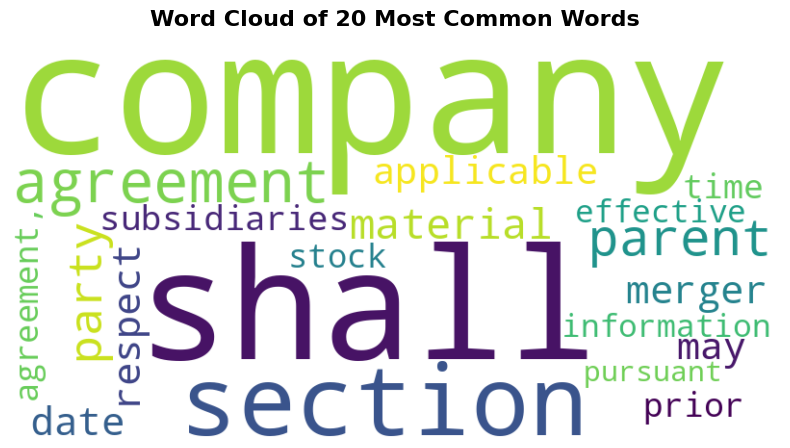

In [46]:
# word cloud  for 20 most common words
from wordcloud import WordCloud

# Create a word cloud from the most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of 20 Most Common Words', fontsize=16, pad=20, color='black', fontweight='bold',)
plt.show()

#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
# Transform the page contents of documents
# Take first 10 documents
subset_docs = docs[:10]

# extract the text content from subset_docs
documents_text = [doc.page_content for doc in subset_docs]

# Vectorize the documents using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents_text)

# Compute similarity scores
similarity_matrix = cosine_similarity(tfidf_matrix)

# Display the 3 similarity scores
print("Similarity scores for the first 3 documents:")
for i in range(3):
    print(f"Document {i+1}: {similarity_matrix[i]}")


Similarity scores for the first 3 documents:
Document 1: [1.         0.26971714 0.60257809 0.48480418 0.50785621 0.55648004
 0.57321136 0.70233178 0.43619587 0.54373699]
Document 2: [0.26971714 1.         0.27438624 0.20114994 0.21927664 0.23430334
 0.22732688 0.25520159 0.24895088 0.24935309]
Document 3: [0.60257809 0.27438624 1.         0.63127777 0.68752384 0.70919393
 0.71713148 0.75051869 0.40434704 0.6816036 ]


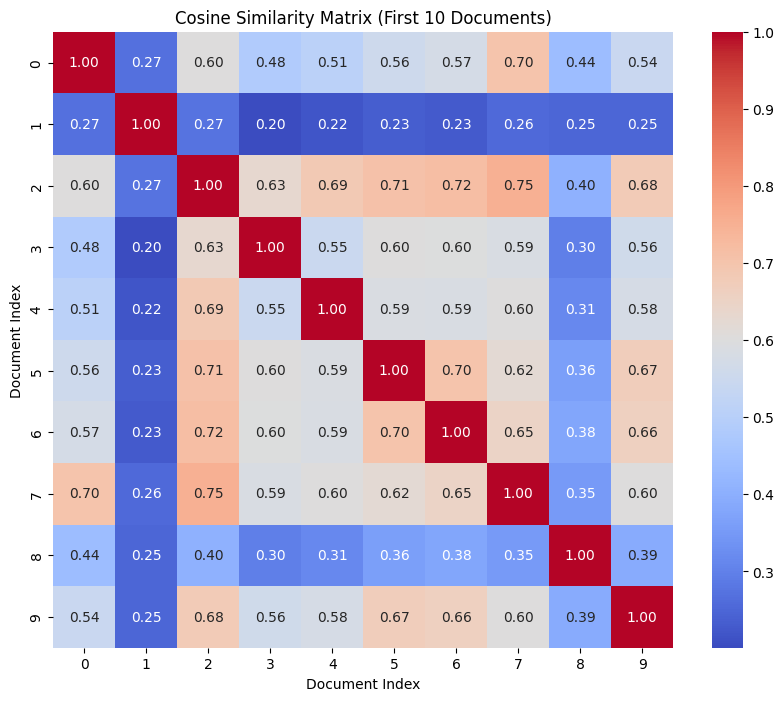

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cosine Similarity Matrix (First 10 Documents)")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()

In [12]:
import random
# create a list of 10 random integers
random_integers = [random.randint(1, 100) for _ in range(10)]
print(random_integers)


[25, 8, 19, 12, 92, 11, 41, 25, 68, 73]


In [13]:
# Compute similarity scores for 10 random documents
# use the random integers to select documents
random_docs = [docs[i] for i in random_integers if i < len(docs)]

# extract the text content from random_docs
random_documents_text = [doc.page_content for doc in random_docs]

# Vectorize the random documents using TF-IDF
random_tfidf_matrix = vectorizer.fit_transform(random_documents_text)
# Compute similarity scores for the random documents
random_similarity_matrix = cosine_similarity(random_tfidf_matrix)
# Display the similarity scores for the random documents
print("Similarity scores for the random documents:")
for i in range(len(random_docs)):
    print(f"Document {i+1}: {random_similarity_matrix[i]}")



Similarity scores for the random documents:
Document 1: [1.         0.28766435 0.19882889 0.16797555 0.29630174 0.22644423
 0.23747115 1.         0.16040104 0.30414597]
Document 2: [0.28766435 1.         0.26673295 0.1875682  0.35519001 0.27068438
 0.2777996  0.28766435 0.17844202 0.34381687]
Document 3: [0.19882889 0.26673295 1.         0.18248128 0.66381317 0.59783541
 0.5656078  0.19882889 0.11866374 0.48949326]
Document 4: [0.16797555 0.1875682  0.18248128 1.         0.23805899 0.18433019
 0.18862502 0.16797555 0.11940436 0.24063658]
Document 5: [0.29630174 0.35519001 0.66381317 0.23805899 1.         0.67760449
 0.64684341 0.29630174 0.18126598 0.62482334]
Document 6: [0.22644423 0.27068438 0.59783541 0.18433019 0.67760449 1.
 0.5645655  0.22644423 0.12988939 0.52671698]
Document 7: [0.23747115 0.2777996  0.5656078  0.18862502 0.64684341 0.5645655
 1.         0.23747115 0.12752112 0.57181284]
Document 8: [1.         0.28766435 0.19882889 0.16797555 0.29630174 0.22644423
 0.23747115

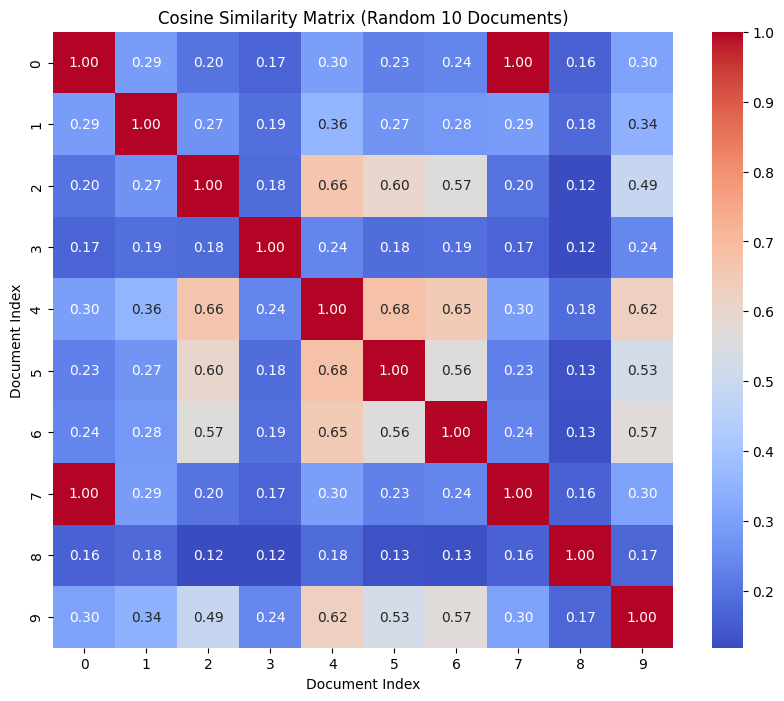

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(random_similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cosine Similarity Matrix (Random 10 Documents)")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()

Conclusion from EDA - Cosine similarity in the range of 0.66–0.70 suggests moderate to high semantic overlap, but not near-perfect duplication (~1.0). This indicates:
 1) The documents may be templated or follow similar structural patterns, such as common legal boilerplate language.
 2) There is likely domain-specific vocabulary reuse, but with enough lexical or clause-level variation to maintain uniqueness.
 3) Moderate similarity is expected in legal documents —they share legal constructs 

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [14]:
# Process files and generate chunks

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", " ", ""]
)

# to hold the chunks 
chunks = []

for doc in docs:
    doc_chunks = text_splitter.split_documents([doc])
    # split_documents  Preserves metadata (e.g., file name, source, category) over split text 
    # Returns a list of Document objects — ideal for use in vector stores and RAG pipelines.
    chunks.extend(doc_chunks)


#check how many chunks were created
print(f"Total chunks created: {len(chunks)}")  



Total chunks created: 43241


In [15]:
# print first part of a chunk for checking
print("First chunk content:")
print(chunks[0].page_content[:300])  

First chunk content:
mutual non-disclosure agreement subject matter: effective date agreement: period , 2017 exchange information: , 2017 period confidentiality: agreement made effective date agreement noted above, parties. background: i. parties desire discussions relating subject matter purposes evaluating possible bu


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [16]:
from getpass import getpass
# Fetch your OPENAI API Key as an environment variable
api_key = getpass("Enter your OpenAI API key: ")
os.environ["GROQ_API_KEY"] = api_key


In [17]:
# Initialise an embedding function

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


# Local cache store (saves embedding bytes keyed by hash)
store = LocalFileStore("./embedding_cache")

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    embedding_model ,
    store,
    namespace=embedding_model.model_name  # avoids collisions with different models
)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12180\204824958.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain\embeddings\cache.py:58: UserWarning: Using default key encoder: SHA‑1 is *not* collision‑resistant. While acceptable for most cache scenarios, a motivated attacker can craft two different payloads that map to the same cache key. If that risk matters in your environment, supply a stronger encoder (e.g. SHA‑256 or BLAKE2) via the `key_encoder` argument. If you change the key enc

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [18]:
# Add Chunks to vector DB
# vectorstore = FAISS.from_documents(chunks, cached_embedder)

# # # Save the vectorstore to disk
# vectorstore.save_local("rag_legal_vectorstore_Groq")

# # # to load the vectorstore from disk
# vectorstore = FAISS.load_local(
#     "rag_legal_vectorstore_Groq", 
#     cached_embedder,
#     allow_dangerous_deserialization=True
# )

vectorstore = FAISS.load_local("rag_legal_vectorstore_Groq", cached_embedder, allow_dangerous_deserialization=True)


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [19]:
# create a retriever from the vectorstore for top 3 results
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [20]:
llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192"
)

In [21]:
prompt = ChatPromptTemplate.from_template("""
You are a legal assistant AI. Use the following context to answer the question concisely.

Context:
{context}

Question:
{question}
""")

In [22]:
# Create a RAG chain
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
)

#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [23]:
# Create a function for question answering
def ask_legal_question(rag_chain, question: str) -> str:
    try:
        response = rag_chain.invoke(question)
        return response.content
    except Exception as e:
        # retunr the error message
        return f"Error: {str(e)}"

Lnahchain Embeds the question using the same embedding model used to build the vectorstore (e.g., OpenAIEmbeddings).

In [24]:
# Example question
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
answer = ask_legal_question(rag_chain, question)
print("Answer:", answer)

Answer: Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. Specifically, it states: "notwithstanding mentors right assess rate ideas participants, mentor shall use confidential information hisher third parties purposes shall file intellectual property right protection confidential information parts it." This implies that the Receiving Party (mentor) does not acquire any rights to the Confidential Information, and any use or protection of such information is limited to the purposes specified in the Agreement.


## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [25]:
import json

In [26]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set
def load_benchmark_data(benchmark_dir: str):
    benchmark_data = []
    for file_name in ['contractnli.json', 'cuad.json', 'maud.json', 'privacy_qa.json']:
        file_path = os.path.join(benchmark_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if 'tests' in data:
                for item in data['tests']:
                    question = item.get('query', '')
                    if item.get("snippets"):
                        for snippet in item["snippets"]:
                            answer = snippet.get('answer', '')
                            benchmark_data.append({
                                "question": question,
                                "answer": answer.strip()
                            })
    return benchmark_data

In [27]:
benchmark_data = load_benchmark_data("./rag_legal/benchmarks")

In [28]:
benchmark_data[0:5]  # Display the first 5 questions and answers from the benchmark data

[{'question': 'Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?',
  'answer': 'Any and all proprietary rights, including but not limited to rights to and in inventions, patent rights, utility models, copyrights, trademarks and trade secrets, in and to any Confidential Information shall be and remain with the Participants respectively, and Mentor shall not have any right, license, title or interest in or to any Confidential Information, except the limited right to review, assess and help develop such Confidential Information in connection with the Copernicus Accelerator 2017.'},
 {'question': 'Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document state that Confidential Information shall only include technical information?',
  'answer': '“Confidential Information” means any Idea disclosed to Mentor, all data a

#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [29]:
def evaluate_rag_chain(rag_chain, benchmark_data):
    predictions = []
    for item in benchmark_data:
        question = item["question"]
        true_answer = item["answer"]
        try:
            response = rag_chain.invoke(question)
            predicted_answer = response.content if hasattr(response, "content") else str(response)
        except Exception as e:
            predicted_answer = f"Error: {e}"

        predictions.append({
            "question": question,
            "true_answer": true_answer,
            "predicted_answer": predicted_answer
        })

    return predictions

In [30]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [31]:
# Function to evaluate the RAG pipeline
def compute_scores(predictions):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    results = []

    for item in predictions:
        ref = item["true_answer"]
        hyp = item["predicted_answer"]

        # ROUGE
        rouge = scorer.score(ref, hyp)["rougeL"].fmeasure

        # BLEU
        smoothie = SmoothingFunction().method4
        bleu = sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothie)

        results.append({
            "question": item["question"],
            "true_answer": ref,
            "predicted_answer": hyp,
            "rougeL": round(rouge, 4),
            "bleu": round(bleu, 4)
        })

    return results

In [32]:
benchmark_data = load_benchmark_data("./rag_legal/benchmarks")

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [33]:
# Evaluate the RAG pipeline

predictions = evaluate_rag_chain(rag_chain, benchmark_data[:100])
results = compute_scores(predictions)

# print the average scores
average_rougeL = sum(r["rougeL"] for r in results) / len(results)
average_bleu = sum(r["bleu"] for r in results) / len(results)
print(f"Average ROUGE-L: {average_rougeL:.4f}")
print(f"Average BLEU: {average_bleu:.4f}")

Average ROUGE-L: 0.2106
Average BLEU: 0.0413


Average ROUGE-L: 0.2221
Average BLEU: 0.0488

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

We did the embedding and the open sourced model for 100 documents we received 
ROUGE-L: Measures the overlap between the predicted and reference (true) answers, especially focusing on sequence — it checks how well the order of words is preserved.
ROUGE-L = 0.2564:
This shows some overlap in sequences between the generated and actual answers.
Not great, but not zero — there is semantic or lexical similarity.
In real-world open-ended QA or summarization, a ROUGE-L around 0.2–0.3 is considered moderate.

BLEU checks how many n-grams (1-gram, 2-gram, etc.) in the prediction match those in the reference. It emphasizes precision, not recall. That means it cares how many of the words/phrases in the predicted answer are correct (not if you caught everything).
BLEU scores also range from 0 to 1 
BLEU = 0.02:
Quite low — indicating that very few exact n-gram matches exist.
Common in open-ended, abstractive answers where phrasing can vary a lot.
BLEU works best for exact matches or short answer generation; less effective in legal QA or paraphrased answers.

I tried changign prompts to make it specific search but that lead to lower rogue as so answers are generic answers 
